In [1]:
import os
import pandas as pd
import pandas as pd
import datetime as dt
import pandas as pd
import json
from datetime import datetime, timedelta

#test git 3
# Thư mục chứa các file CSV
folder_path = r"C:\Users\loint\_repos\retail_customer_analysis\retail_customer_data"

# Duyệt qua tất cả file trong thư mục
for file in os.listdir(folder_path):

    # Chỉ lấy file CSV
    if file.endswith(".csv"):

        # Full path tới file
        file_path = os.path.join(folder_path, file)

        # Lấy tên file (bỏ .csv)
        # campaigns.csv -> campaigns
        df_name = file.replace(".csv", "")

        # Tạo tên biến theo format: <tên_file>
        # campaigns -> campaigns
        var_name = f"{df_name}"

        # Đọc CSV và gán vào biến tạm trong global scope
        globals()[var_name] = pd.read_csv(file_path)

        print(f"Loaded {file} -> variable '{var_name}'")


Loaded campaigns.csv -> variable 'campaigns'
Loaded customers.csv -> variable 'customers'
Loaded customer_reviews_complete.csv -> variable 'customer_reviews_complete'
Loaded interactions.csv -> variable 'interactions'
Loaded support_tickets.csv -> variable 'support_tickets'
Loaded transactions.csv -> variable 'transactions'


In [2]:


# Giả lập input từ n8n
df = transactions.copy() # Trong n8n thực tế: pd.DataFrame(_input.all())

# 1. Xử lý dữ liệu
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
last_date = df['transaction_date'].max()
analysis_date = last_date + dt.timedelta(days=1)

# 2. Aggregation: Tính Min/Max Date và Count
# Chúng ta cần Max Date để tính Recency, và Min/Max để tính Lifespan
rfm = df.groupby('customer_id').agg({
    'transaction_date': ['min', 'max'], # Lấy ngày đầu và ngày cuối
    'transaction_id': 'count',          # Đếm số lần mua
    'price': 'sum'                      # Tổng tiền (Lifetime Monetary)
})

# Làm phẳng MultiIndex (do groupby tạo ra)
rfm.columns = ['min_date', 'max_date', 'count', 'amount']
rfm = rfm.reset_index()

# 3. Tính toán các chỉ số RFM
# Recency: Số ngày từ lần mua cuối cùng
rfm['Recency'] = (analysis_date - rfm['max_date']).dt.days

# Tính vòng đời (Năm)
# Cộng thêm 0.0001 để tránh lỗi chia cho 0 nếu khách mua nhiều lần trong cùng 1 ngày
rfm['lifespan_days'] = (rfm['max_date'] - rfm['min_date']).dt.days
rfm['lifespan_years'] = rfm['lifespan_days'] / 365.0

# --- CÔNG THỨC FREQUENCY MỚI ---
def calculate_f_rate(row):
    # Nếu chỉ mua 1 lần -> Chưa có tần suất -> Gán bằng 0
    if row['count'] <= 1:
        return 0.0
    
    # Nếu mua nhiều lần trong cùng 1 ngày (lifespan = 0) -> Tần suất cực cao
    if row['lifespan_years'] == 0:
        return row['count'] * 365.0 # Quy đổi tương đương mua hàng ngày
        
    return row['count'] / row['lifespan_years']

rfm['Frequency_Rate'] = rfm.apply(calculate_f_rate, axis=1)

# Monetary: Vẫn giữ Lifetime Value để bắt được VIP
rfm['Monetary'] = rfm['amount']

# 4. Tính điểm (Score) 1-5
# Recency: Thấp là tốt (5 điểm)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=['5', '4', '3', '2', '1'])

# Frequency Rate: Cao là tốt (5 điểm)
# Lưu ý: F_Rate = 0 (khách mua 1 lần) sẽ tự động rơi vào nhóm 1
rfm['F_Score'] = pd.qcut(rfm['Frequency_Rate'].rank(method='first'), 5, labels=['1', '2', '3', '4', '5'])

# Monetary: Cao là tốt (5 điểm)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=['1', '2', '3', '4', '5'])

# Tạo chuỗi RFM
rfm['rfm_score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# 5. Phân loại Segment (Actionable Groups)
def assign_segment(row):
    r = int(row['R_Score'])
    f = int(row['F_Score'])
    m = int(row['M_Score'])
    
    if r >= 5 and f >= 5 and m >= 5: return 'Champions'
    elif r >= 4 and f >= 4 and m >= 4: return 'Loyal Customers'
    elif r <= 2 and m >= 4: return 'At Risk' # Quan trọng: Giữ khách giàu có nhưng sắp đi
    elif r >= 3 and f >= 3 and m >= 3: return 'Potential Loyalist'
    elif r >= 4 and f <= 2: return 'New Customers'
    elif r <= 2 and m <= 2: return 'Hibernating'
    else: return 'Need Attention'

rfm['target_segment_tag'] = rfm.apply(assign_segment, axis=1)

# Output JSON cho n8n
output_data = rfm.to_dict(orient='records')
# return output_data

rfm = pd.DataFrame(output_data)
# Advanced Engagement Score Calculation
# -----------------------------------------------------------

def calculate_advanced_engagement(interactions_df):
    # 1. Định nghĩa trọng số (Intent-based Weights)
    weights = {
        'purchase': 10,
        'checkout': 8,
        'add_to_cart': 7,
        'wishlist_add': 5,
        'review': 5,
        'search': 3,
        'product_view': 2,
        'page_view': 1,
        'session_start': 1
    }
    
    # Map trọng số vào DataFrame
    interactions_df['base_score'] = interactions_df['interaction_type'].map(weights).fillna(1)
    
    # 2. Xử lý Time Decay (Giảm điểm theo thời gian)
    # Chuyển đổi cột ngày tháng
    interactions_df['interaction_date'] = pd.to_datetime(interactions_df['interaction_date'])
    
    # Lấy ngày mới nhất trong dữ liệu làm mốc hiện tại
    current_date = interactions_df['interaction_date'].max()
    
    # Tính khoảng cách ngày: (Ngày hiện tại - Ngày tương tác)
    interactions_df['days_diff'] = (current_date - interactions_df['interaction_date']).dt.days
    
    # Công thức Decay: Điểm giảm dần. Ví dụ hệ số 0.05 nghĩa là điểm sẽ giảm đáng kể sau 20 ngày.
    interactions_df['decayed_score'] = interactions_df['base_score'] / (1 + interactions_df['days_diff'] * 0.05)
    
    # 3. Tổng hợp (Aggregation) - Bao gồm cả Top Interest
    customer_profile = interactions_df.groupby('customer_id').agg(
        # Tổng điểm Engagement đã trừ hao thời gian
        engagement_score=('decayed_score', 'sum'),
        
        # Ngày tương tác cuối cùng
        last_interaction=('interaction_date', 'max'),
        
        # Đếm số lần Checkout để bắt nhóm High Intent
        checkout_count=('interaction_type', lambda x: (x == 'checkout').sum()),
        
        # Đếm số lần đã mua
        purchase_count=('interaction_type', lambda x: (x == 'purchase').sum()),
        
        # --- PHẦN BẠN YÊU CẦU THÊM ---
        # Tìm sản phẩm/trang quan tâm nhất (Mode)
        top_interest=('page_or_product', lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')
    ).reset_index()
    
    # Làm tròn điểm số cho đẹp
    customer_profile['engagement_score'] = customer_profile['engagement_score'].round(2)
    
    return customer_profile

def build_customer_context_v2(customer_id, rfm, customers, transactions, interactions):
    """
    Hàm này nhận cả bảng customers để tra cứu tên, tránh lỗi KeyError.
    """
    
    # --- A. LẤY THÔNG TIN CÁ NHÂN (Từ Customers CSV) ---
    try:
        cust_record = customers[customers['customer_id'] == customer_id].iloc[0]
        full_name = cust_record['full_name']
        location = f"{cust_record['city']}, {cust_record['state']}"
    except (IndexError, KeyError):
        # Fallback nếu không tìm thấy trong file customers
        full_name = "Unknown Customer"
        location = "Unknown Location"

    # --- B. LẤY PHÂN KHÚC (Từ RFM Table có sẵn) ---
    try:
        rfm_record = rfm[rfm['customer_id'] == customer_id].iloc[0]
        segment_info = f"{rfm_record['target_segment_tag']} (RFM: {rfm_record['rfm_score']})"
    except (IndexError, KeyError):
        segment_info = "Unsegmented"

    # --- C. LẤY LỊCH SỬ MUA HÀNG (Từ Transactions CSV) ---
    transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
    cust_trans = transactions[transactions['customer_id'] == customer_id].sort_values('transaction_date', ascending=False)
    
    history_list = []
    for _, row in cust_trans.iterrows():
        date_str = row['transaction_date'].strftime('%Y-%m-%d')
        item = f"{row['product_name']} ({row['product_category']}) - ${row['price']} - {date_str}"
        history_list.append(item)

    # --- D. LẤY TƯƠNG TÁC GẦN ĐÂY (Từ Interactions CSV) ---
    interactions['interaction_date'] = pd.to_datetime(interactions['interaction_date'])
    simulated_now = interactions['interaction_date'].max() # Trong thực tế dùng datetime.now()
    cutoff_date = simulated_now - timedelta(days=90)
    
    cust_inter = interactions[
        (interactions['customer_id'] == customer_id) & 
        (interactions['interaction_date'] >= cutoff_date)
    ].sort_values('interaction_date', ascending=False)
    
    interaction_list = []
    for _, row in cust_inter.iterrows():
        inter = {
            "product": row['page_or_product'],
            "action": row['interaction_type'],
            "duration": f"{int(row['duration'])}s" if pd.notna(row['duration']) else "0s",
            "date": row['interaction_date'].strftime('%Y-%m-%d')
        }
        interaction_list.append(inter)

    # --- E. TRẢ VỀ JSON ---
    return {
        "customer_profile": {
            "id": customer_id,
            "name": full_name,      # Đã lấy từ customers
            "segment": segment_info, # Đã lấy từ rfm
            "location": location
        },
        "purchase_history": history_list,
        "recent_interactions_last_90_days": interaction_list
    }




In [3]:
# --- PHẦN GIẢ LẬP ĐỂ CHẠY TRONG TERMINAL (Trong n8n thì bỏ qua phần này)
# interactions_df = pd.read_csv('interactions.csv')
e_score = calculate_advanced_engagement(interactions)

e_score = e_score[['customer_id', 'engagement_score', 'last_interaction','top_interest']]

rfm_df = rfm[['customer_id', 'Recency',
        'Frequency_Rate', 'Monetary',
       'R_Score', 'F_Score', 'M_Score', 'rfm_score', 'target_segment_tag']]

# Merge 1: Customers + RFM
merged_df = customers.merge(rfm_df, on='customer_id', how='left')

# Merge 2: Result + Engagement
final_df = merged_df.merge(e_score, on='customer_id', how='left')

# Fill NaNs
final_df['Recency'] = final_df['Recency'].fillna(999) # Or some high number
final_df['Frequency_Rate'] = final_df['Frequency_Rate'].fillna(0)
final_df['Monetary'] = final_df['Monetary'].fillna(0)
final_df['engagement_score'] = final_df['engagement_score'].fillna(0)
final_df['top_interest'] = final_df['top_interest'].fillna('Unknown')
final_df['target_segment_tag'] = final_df['target_segment_tag'].fillna('Unknown')
final_df

,customer_id,full_name,age,gender,email,phone,street_address,city,state,zip_code,...,Frequency_Rate,Monetary,R_Score,F_Score,M_Score,rfm_score,target_segment_tag,engagement_score,last_interaction,top_interest
0,4c30e132-0704-4459-a509-9eddde934977,Mark Johnson,40.0,Male,mark.johnson@yahoo.com,989.608.3863,819 Johnson Course,Houston,Texas,29158.0,...,7.877698,3565.72,4,5,3,453,Potential Loyalist,7.35,2024-12-27 13:30:00,category_gaming
1,68bec407-275f-4b5b-9a82-13d02f54626a,Robert Smith,33.0,Male,smithr@yahoo.com,(518)349-5931x0341,35116 Michael Key Suite 078,Austin,Texas,16862.0,...,3.122624,5660.76,2,2,4,224,At Risk,0.58,2023-10-08 19:53:00,Amazon Echo
2,4466459f-76c8-433c-814e-6d59cb4131fc,Jamie Chavez,42.0,Female,jchavez@gmail.com,364.583.5030x564,419 Amanda Gardens,Detroit,Michigan,21918.0,...,4.066852,2274.92,5,4,2,542,Need Attention,24.09,2025-02-08 09:07:00,category_smartphones
3,04c36a25-02f3-462c-92b0-6bf291c57706,Thomas Bradley,53.0,Male,thomas.bradley@hotmail.com,(332)887-1012x269,7242 Julie Plain Suite 969,Fort Worth,Texas,52851.0,...,3.910714,1568.62,4,3,2,432,Need Attention,5.90,2025-01-26 20:32:00,Sofa
4,e916df3d-c3f5-40b0-8ae2-5d043be88300,Jane Ferrell,32.0,Female,jane.ferrell@hotmail.com,5484281489,845 Kelly Estate,Atlanta,Georgia,59971.0,...,4.380000,7128.56,2,4,5,245,At Risk,1.58,2024-10-01 18:22:00,blog
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,e0464b5f-5d5f-4451-872d-641f003bae1d,Andrew Kennedy,34.0,Male,andrew_kennedy@gmail.com,400.378.2734,12590 Allison Bypass Suite 636,Tampa,Florida,54707.0,...,3.665092,12287.86,3,3,5,335,Potential Loyalist,1.82,2024-12-14 11:43:00,home
4996,2252e41a-d482-41a4-8962-15a86d48099f,Autumn Martin,43.0,Female,autumn_martin@gmail.com,001-447-839-5231x6761,74328 James Villages Apt. 727,Allentown,Pennsylvania,17520.0,...,0.000000,0.00,NaN,NaN,NaN,NaN,Unknown,35.92,2025-02-25 10:04:00,Coffee Maker
4997,fb4e194c-7591-4017-b298-d84cddbce122,Laurie Miller,72.0,Female,millerl@hotmail.com,001-549-978-4978x0862,37521 Joseph Dam Suite 919,Buffalo,New York,31641.0,...,4.314421,3454.31,3,4,3,343,Potential Loyalist,3.13,2025-01-31 16:11:00,Bose Headphones
4998,dc613206-b470-492e-b156-29c183c6de44,William Edwards,44.0,Male,william_edwards@gmail.com,666-309-0883,309 Thompson Lights Apt. 978,San Antonio,Texas,41162.0,...,4.724919,5752.50,4,4,4,444,Loyal Customers,3.01,2025-01-02 11:21:00,Amazon Echo


In [6]:
final_df.columns

Index(['customer_id', 'full_name', 'age', 'gender', 'email', 'phone',
       'street_address', 'city', 'state', 'zip_code', 'registration_date',
       'preferred_channel', 'Recency', 'Frequency_Rate', 'Monetary', 'R_Score',
       'F_Score', 'M_Score', 'rfm_score', 'target_segment_tag',
       'engagement_score', 'last_interaction', 'top_interest'],
      dtype='object')


📌 SUMMARY STATISTICS (TỔNG QUAN)
           age  Recency  Frequency_Rate  Monetary  engagement_score
count  4814.00  5000.00         5000.00   5000.00           5000.00
mean     35.04   199.38            5.78   3943.11             15.68
std      11.08   268.03           28.45   3399.56             26.15
min      18.00     1.00            0.00      0.00              0.00
25%      27.00    52.00            2.09   1281.94              2.17
50%      35.00    93.00            3.36   3220.78              6.28
75%      42.00   204.00            4.79   5826.15             17.31
max      80.00  1087.00          730.00  30332.60            269.00

📌 SEGMENT BREAKDOWN (PHÂN LOẠI KHÁCH HÀNG)
                    Count  Percentage (%)
target_segment_tag                       
Need Attention       1298            26.0
Potential Loyalist    861            17.2
Hibernating           828            16.6
New Customers         631            12.6
At Risk               624            12.5
Unknown         

C:\Users\loint\AppData\Local\Temp\ipykernel_6908\1598205635.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.values, y=segment_counts.index, ax=axes[0, 0], palette='viridis')
C:\Users\loint\AppData\Local\Temp\ipykernel_6908\1598205635.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_stats.values, y=revenue_stats.index, ax=axes[0, 1], palette='magma')
C:\Users\loint\AppData\Local\Temp\ipykernel_6908\1598205635.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_interests.values, y=top_interests.index,


✅ Đã xuất biểu đồ ra file 'glance_view_report.png'


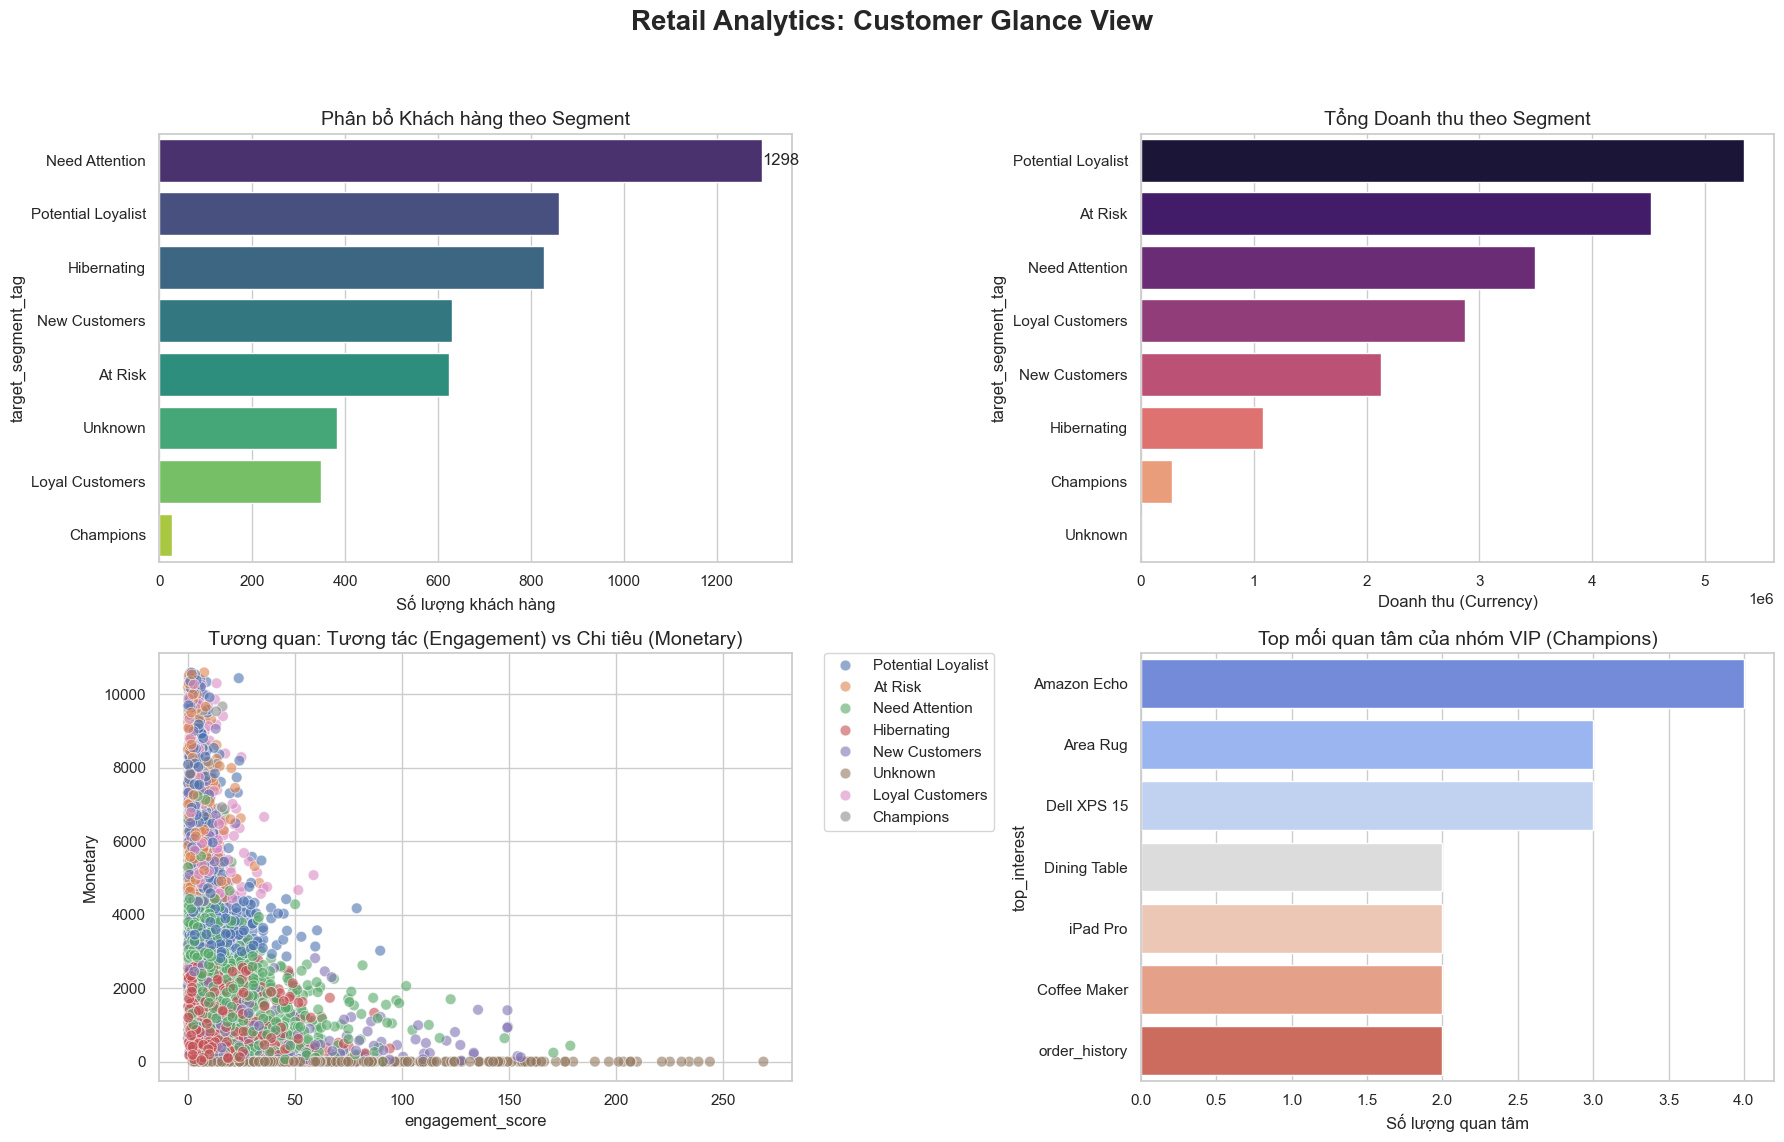

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. CONFIGURATION & LOAD DATA
# ==========================================
# Thay đổi tên file nếu file của bạn có tên khác
FILE_PATH = 'final_customer_rfm_e.csv' 

try:
    df =final_df.copy()
    # print(f"✅ Đã load ?thành công file '{FILE_PATH}'")
    # print(f"📊 Kích thước dữ liệu: {df.shape[0]} hàng, {df.shape[1]} cột")
except FileNotFoundError:
    print(f"❌ Không tìm thấy file '{FILE_PATH}'. Vui lòng kiểm tra lại đường dẫn.")
    exit()

# Cấu hình giao diện biểu đồ
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# ==========================================
# 2. DATA STATISTICS (THỐNG KÊ SỐ LIỆU)
# ==========================================
print("\n" + "="*40)
print("📌 SUMMARY STATISTICS (TỔNG QUAN)")
print("="*40)

# Các cột số quan trọng
numeric_cols = ['age', 'Recency', 'Frequency_Rate', 'Monetary', 'engagement_score']
print(df[numeric_cols].describe().round(2))

print("\n" + "="*40)
print("📌 SEGMENT BREAKDOWN (PHÂN LOẠI KHÁCH HÀNG)")
print("="*40)
segment_counts = df['target_segment_tag'].value_counts()
segment_percent = df['target_segment_tag'].value_counts(normalize=True) * 100

segment_stats = pd.DataFrame({
    'Count': segment_counts,
    'Percentage (%)': segment_percent.round(1)
})
print(segment_stats)

print("\n" + "="*40)
print("📌 REVENUE BY SEGMENT (DOANH THU THEO NHÓM)")
print("="*40)
revenue_stats = df.groupby('target_segment_tag')['Monetary'].sum().sort_values(ascending=False)
for segment, revenue in revenue_stats.items():
    print(f"{segment}: ${revenue:,.2f}")

# ==========================================
# 3. VISUALIZATION (VẼ BIỂU ĐỒ)
# ==========================================

# Tạo khung hình 2x2 cho Dashboard
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Retail Analytics: Customer Glance View', fontsize=20, weight='bold')

# --- CHART 1: Số lượng khách hàng theo Segment ---
sns.barplot(x=segment_counts.values, y=segment_counts.index, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Phân bổ Khách hàng theo Segment', fontsize=14)
axes[0, 0].set_xlabel('Số lượng khách hàng')
axes[0, 0].bar_label(axes[0, 0].containers[0]) # Hiển thị số liệu trên thanh

# --- CHART 2: Doanh thu theo Segment ---
sns.barplot(x=revenue_stats.values, y=revenue_stats.index, ax=axes[0, 1], palette='magma')
axes[0, 1].set_title('Tổng Doanh thu theo Segment', fontsize=14)
axes[0, 1].set_xlabel('Doanh thu (Currency)')

# --- CHART 3: Engagement vs Monetary (Scatter Plot) ---
# Lọc bớt nhiễu (outliers) để biểu đồ đẹp hơn (chỉ lấy 95% dữ liệu)
q_high = df["Monetary"].quantile(0.95)
df_filtered = df[df["Monetary"] < q_high]

sns.scatterplot(
    data=df_filtered, 
    x='engagement_score', 
    y='Monetary', 
    hue='target_segment_tag', 
    alpha=0.6, 
    s=60,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Tương quan: Tương tác (Engagement) vs Chi tiêu (Monetary)', fontsize=14)
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# --- CHART 4: Top Interest của nhóm VIP (Champions) ---
# Lọc nhóm Champions
vip_df = df[df['target_segment_tag'] == 'Champions']
top_interests = vip_df['top_interest'].value_counts().head(7)

sns.barplot(x=top_interests.values, y=top_interests.index, ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title('Top mối quan tâm của nhóm VIP (Champions)', fontsize=14)
axes[1, 1].set_xlabel('Số lượng quan tâm')

# Điều chỉnh layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Lưu hoặc hiển thị
plt.savefig('glance_view_report.png') # Lưu file ảnh
print("\n✅ Đã xuất biểu đồ ra file 'glance_view_report.png'")
plt.show() # Hiển thị cửa sổ (nếu chạy local)

In [10]:
pip install pandas matplotlib seaborn  

     ---------------------------------------- 0.0/52.8 kB ? eta -:--:--
     -------------- ----------------------- 20.5/52.8 kB 330.3 kB/s eta 0:00:01
     ------------------------------------ - 51.2/52.8 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 52.8/52.8 kB 390.8 kB/s eta 0:00:00
     ---------------------------------------- 0.0/116.4 kB ? eta -:--:--
     ------------------------ -------------- 71.7/116.4 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 116.4/116.4 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
    --------------------------------------- 0.1/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.2/8.1 MB 2.5 MB/s eta 0:00:04
   - -------------------------------------- 0.2/8.1 MB 2.5 MB/s eta 0:00:04
   -- ------------------------------------- 0.5/8.1 MB 2.6 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/8.1 MB 2.6 MB/s eta 0:00:03
   ---- -----

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
rfm = pd.DataFrame(output_data)
# -----------------------------------------------------------
# 3. CHẠY THỬ NGHIỆM
# -----------------------------------------------------------
customer_id_demo = "00012aa8-e99c-4e30-b3f6-1f7e36adc517"
# cus_id = '01f30800-c880-44d9-a114-4219284844b3'
# Gọi hàm với đầy đủ 4 bảng dữ liệu
output = build_customer_context_v2(
    customer_id_demo, 
    rfm,   # Bảng chứa Segment
    customers,      # Bảng chứa Tên/Tuổi (QUAN TRỌNG ĐỂ FIX LỖI)
    transactions,   # Bảng lịch sử mua
    interactions    # Bảng web tracking
)
# print(json.dumps(output, indent=2))
output

{'customer_profile': {'id': '00012aa8-e99c-4e30-b3f6-1f7e36adc517',
  'name': 'Ruth White',
  'segment': 'Need Attention (RFM: 532)',
  'location': 'Vancouver, Washington'},
 'purchase_history': ['Samsung Galaxy S22 (Smartphones) - $1074.59 - 2025-01-21',
  'Google Pixel 6 (Smartphones) - $625.34 - 2024-12-23',
  'Range Hood (Kitchen Appliances) - $452.51 - 2024-12-11',
  'Amazon Echo (Smart Home Devices) - $107.09 - 2024-05-10',
  'Dishwasher (Kitchen Appliances) - $474.93 - 2023-10-21'],
 'recent_interactions_last_90_days': [{'product': 'category_laptops',
   'action': 'search',
   'duration': '31s',
   'date': '2025-01-24'},
  {'product': 'category_smart_home',
   'action': 'search',
   'duration': '52s',
   'date': '2025-01-16'}]}